In [1]:
import pandas as pd
import numpy as np
import random
%matplotlib inline
import matplotlib.pyplot as plt
import surprise
from surprise import SVD, SVDpp, NMF
from surprise import Dataset
from surprise import Reader
from surprise import evaluate, print_perf
from surprise import KNNBasic
from surprise import AlgoBase, BaselineOnly
from get_top_n import get_top_n
from surprise import GridSearch
from surprise.accuracy import rmse, mae

# Set up training & test data

In [2]:
#Load data
dt = pd.read_csv('sample_data.csv',index_col=0)
dt.head()

,reviewerID,productID,rating,date
370183,A2OR4QUQSUMOW7,B0016B9FSU,4.0,2013-01-31
370186,A14E7LZASLSX36,B0016B9FSU,5.0,2013-03-21
370189,A9ESHA5MS6S6L,B0016B9FSU,5.0,2013-01-17
370192,ATATZGNDHA5ZD,B0016B9FSU,5.0,2013-02-05
370193,AN4HRAGRHHX1H,B0016B9FSU,5.0,2013-01-03


In [3]:
#Construct missing ratings we need to predict
select_data = dt.pivot_table('rating',index=['reviewerID','productID'],dropna=False)
select_data = select_data.loc[select_data['rating'].isnull()]
select_data.reset_index(inplace=True)
missing_values = select_data[['reviewerID','productID']].values

In [4]:
reader = Reader(rating_scale=(1,5))
dt = Dataset.load_from_df(dt[['reviewerID','productID','rating']],reader)

In [5]:
raw_ratings = dt.raw_ratings
#Shuffle ratings
random.seed(42)
random.shuffle(raw_ratings)
#Split to training and test sets
threshold = int(.8 * len(raw_ratings))
A_raw_ratings = raw_ratings[:threshold]
B_raw_ratings = raw_ratings[threshold:]

In [6]:
dt.raw_ratings = A_raw_ratings  # dt is now the set A
dt.split(n_folds=3)

In [7]:
#Construct train set and test set for use by surprise
trainset = dt.build_full_trainset() # trainset is set A
testset = dt.construct_testset(B_raw_ratings)  # testset is set B

# Train Models

## Baseline Model

In [8]:
#Baseline model: User's bias & item's bias
class BaselineModel(AlgoBase):

    def __init__(self):
        AlgoBase.__init__(self)

    def compute_bias(self):
        bu = np.zeros(self.trainset.n_users)
        bi = np.zeros(self.trainset.n_items)
        global_mean = self.trainset.global_mean
        
        for i in self.trainset.all_items():
            dev_i = 0
            for (u, r) in self.trainset.ir[i]:
                dev_i += r - global_mean
            bi[i] = dev_i/(len(self.trainset.ir[i]))
        
        for u in self.trainset.all_users():
            dev_u = 0
            for (i, r) in self.trainset.ur[u]:
                dev_u += r - global_mean
            bu[u] = dev_u/(len(self.trainset.ur[u]))
        return bu, bi
    
    def train(self, trainset):
        AlgoBase.train(self, trainset)
        self.bu, self.bi = self.compute_bias()

    def estimate(self, u, i):
        est = self.trainset.global_mean
        if self.trainset.knows_user(u):
            est += self.bu[u]
        if self.trainset.knows_item(i):
            est += self.bi[i]
        return est

algo1 = BaselineModel()

In [9]:
#Train using baseline model and test on testset
evaluate(algo1,dt,measures=['RMSE','MAE'], verbose= 1)
baseline_predictions = algo1.test(testset)

Evaluating RMSE, MAE of algorithm BaselineModel.

------------
Fold 1
RMSE: 1.0403
MAE:  0.7736
------------
Fold 2
RMSE: 1.0510
MAE:  0.7872
------------
Fold 3
RMSE: 1.0457
MAE:  0.7947
------------
------------
Mean RMSE: 1.0457
Mean MAE : 0.7852
------------
------------


In [10]:
#Accuracy on test set
rmse(baseline_predictions)
mae(baseline_predictions)

RMSE: 1.0790
MAE:  0.8137


0.81369601807649294

## Model-based Collaborative Filtering

In [11]:
#SVD
algo2 = SVD()
evaluate(algo2,dt,measures=['RMSE','MAE'], verbose= 1)
svd_predictions = algo2.test(testset)

Evaluating RMSE, MAE of algorithm SVD.

------------
Fold 1
RMSE: 0.9457
MAE:  0.7399
------------
Fold 2
RMSE: 0.9482
MAE:  0.7367
------------
Fold 3
RMSE: 0.9376
MAE:  0.7402
------------
------------
Mean RMSE: 0.9438
Mean MAE : 0.7390
------------
------------


In [12]:
#Accuracy on test set
rmse(svd_predictions)
mae(svd_predictions)

RMSE: 0.9623
MAE:  0.7559


0.75587752384962159

#### Changing hyper-parameters of model-based

In [13]:
#Setting different values for the hyperparameters
param_grid = {'n_factors':[80,90,100,110,120,130], 'n_epochs': [5,10,15,20,25,30,35], 'lr_all': [0.001,0.002,0.003,0.004,0.005],
              'reg_all': [0.04,0.05,0.06,0.07,0.08]}

In [14]:
grid_search = GridSearch(SVD, param_grid, measures=['RMSE','MAE'],verbose=0)
grid_search.evaluate(dt)

[{'n_factors': 80, 'n_epochs': 5, 'lr_all': 0.001, 'reg_all': 0.04}, {'n_factors': 80, 'n_epochs': 5, 'lr_all': 0.001, 'reg_all': 0.05}, {'n_factors': 80, 'n_epochs': 5, 'lr_all': 0.001, 'reg_all': 0.06}, {'n_factors': 80, 'n_epochs': 5, 'lr_all': 0.001, 'reg_all': 0.07}, {'n_factors': 80, 'n_epochs': 5, 'lr_all': 0.001, 'reg_all': 0.08}, {'n_factors': 80, 'n_epochs': 5, 'lr_all': 0.002, 'reg_all': 0.04}, {'n_factors': 80, 'n_epochs': 5, 'lr_all': 0.002, 'reg_all': 0.05}, {'n_factors': 80, 'n_epochs': 5, 'lr_all': 0.002, 'reg_all': 0.06}, {'n_factors': 80, 'n_epochs': 5, 'lr_all': 0.002, 'reg_all': 0.07}, {'n_factors': 80, 'n_epochs': 5, 'lr_all': 0.002, 'reg_all': 0.08}, {'n_factors': 80, 'n_epochs': 5, 'lr_all': 0.003, 'reg_all': 0.04}, {'n_factors': 80, 'n_epochs': 5, 'lr_all': 0.003, 'reg_all': 0.05}, {'n_factors': 80, 'n_epochs': 5, 'lr_all': 0.003, 'reg_all': 0.06}, {'n_factors': 80, 'n_epochs': 5, 'lr_all': 0.003, 'reg_all': 0.07}, {'n_factors': 80, 'n_epochs': 5, 'lr_all': 0.00

In [15]:
grid_search.best_score['RMSE']

0.93530779843181622

In [16]:
grid_search.best_params['RMSE']

{'lr_all': 0.004, 'n_epochs': 25, 'n_factors': 100, 'reg_all': 0.08}

In [17]:
grid_search.best_score['MAE']

0.73139472759537671

In [18]:
grid_search.best_params['MAE']

{'lr_all': 0.005, 'n_epochs': 25, 'n_factors': 110, 'reg_all': 0.07}

#Effect of Hyperparameters on Accuracy (RMSE) of the Model

In [29]:
# Hyperparameter :- Latent Factors

In [19]:
param_grid_factor = {'n_factors':[80,90,100,110,120,130]}
grid_search_factor = GridSearch(SVD, param_grid_factor, measures=['RMSE','MAE'])
grid_search_factor.evaluate(dt)
results_df = pd.DataFrame.from_dict(grid_search_factor.cv_results)
rm=[]
rm=results_df['RMSE']
mae_svd=[]
for d in grid_search_factor.cv_results['scores']:
    mae_svd.append(d['MAE'])
n_ep=results_df['n_factors']

[{'n_factors': 80}, {'n_factors': 90}, {'n_factors': 100}, {'n_factors': 110}, {'n_factors': 120}, {'n_factors': 130}]
------------
Parameters combination 1 of 6
params:  {'n_factors': 80}
------------
Mean RMSE: 0.9386
Mean MAE : 0.7344
------------
------------
Parameters combination 2 of 6
params:  {'n_factors': 90}
------------
Mean RMSE: 0.9417
Mean MAE : 0.7380
------------
------------
Parameters combination 3 of 6
params:  {'n_factors': 100}
------------
Mean RMSE: 0.9419
Mean MAE : 0.7400
------------
------------
Parameters combination 4 of 6
params:  {'n_factors': 110}
------------
Mean RMSE: 0.9435
Mean MAE : 0.7389
------------
------------
Parameters combination 5 of 6
params:  {'n_factors': 120}
------------
Mean RMSE: 0.9432
Mean MAE : 0.7393
------------
------------
Parameters combination 6 of 6
params:  {'n_factors': 130}
------------
Mean RMSE: 0.9432
Mean MAE : 0.7389
------------


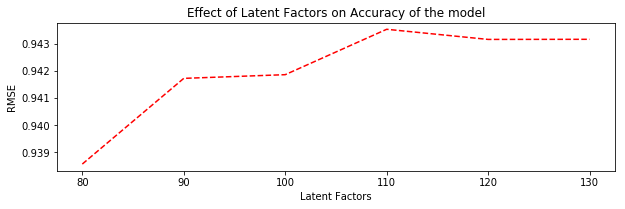

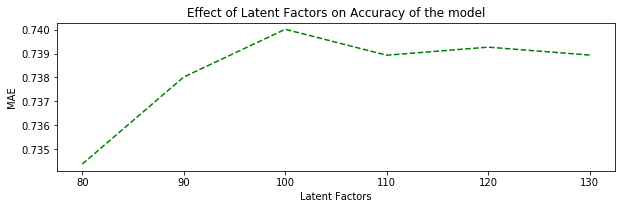

In [20]:
plt.figure(figsize=(10,6))
plt.subplot(2,1,1)
plt.plot(n_ep,rm,'r--')
plt.xlabel('Latent Factors')
plt.ylabel('RMSE')
plt.title('Effect of Latent Factors on Accuracy of the model')
plt.figure(figsize=(10,6))
plt.subplot(2,1,2)
plt.plot(n_ep,mae_svd,'g--')
plt.xlabel('Latent Factors')
plt.ylabel('MAE')
plt.title('Effect of Latent Factors on Accuracy of the model')


In [21]:
param_grid_n_epoch = {'n_epochs':[5,10,15,20,25,30,35]}
grid_search_n_epoch = GridSearch(SVD, param_grid_n_epoch, measures=['RMSE','MAE'])
grid_search_n_epoch.evaluate(dt)
results_df = pd.DataFrame.from_dict(grid_search_n_epoch.cv_results)
rm=[]
rm=results_df['RMSE']
mae_svd=[]
for d in grid_search_n_epoch.cv_results['scores']:
    mae_svd.append(d['MAE'])
n_ep=[]
n_ep=results_df['n_epochs']

[{'n_epochs': 5}, {'n_epochs': 10}, {'n_epochs': 15}, {'n_epochs': 20}, {'n_epochs': 25}, {'n_epochs': 30}, {'n_epochs': 35}]
------------
Parameters combination 1 of 7
params:  {'n_epochs': 5}
------------
Mean RMSE: 0.9561
Mean MAE : 0.7600
------------
------------
Parameters combination 2 of 7
params:  {'n_epochs': 10}
------------
Mean RMSE: 0.9447
Mean MAE : 0.7445
------------
------------
Parameters combination 3 of 7
params:  {'n_epochs': 15}
------------
Mean RMSE: 0.9430
Mean MAE : 0.7410
------------
------------
Parameters combination 4 of 7
params:  {'n_epochs': 20}
------------
Mean RMSE: 0.9426
Mean MAE : 0.7372
------------
------------
Parameters combination 5 of 7
params:  {'n_epochs': 25}
------------
Mean RMSE: 0.9424
Mean MAE : 0.7380
------------
------------
Parameters combination 6 of 7
params:  {'n_epochs': 30}
------------
Mean RMSE: 0.9451
Mean MAE : 0.7405
------------
------------
Parameters combination 7 of 7
params:  {'n_epochs': 35}
------------
Mean RM

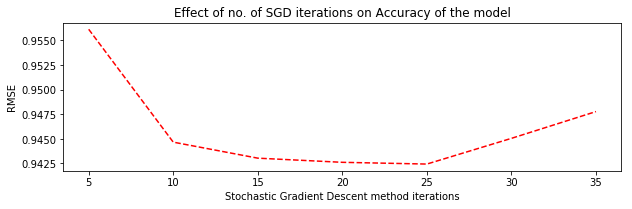

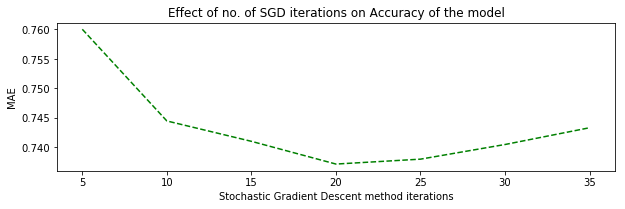

In [22]:
plt.figure(figsize=(10,6))
plt.subplot(2,1,1)
plt.plot(n_ep,rm,'r--')
plt.xlabel('Stochastic Gradient Descent method iterations')
plt.ylabel('RMSE')
plt.title('Effect of no. of SGD iterations on Accuracy of the model')
plt.figure(figsize=(10,6))
plt.subplot(2,1,1)
plt.plot(n_ep,mae_svd,'g--')
plt.xlabel('Stochastic Gradient Descent method iterations')
plt.ylabel('MAE')
plt.title('Effect of no. of SGD iterations on Accuracy of the model')

In [23]:
param_grid_lr = {'lr_all': [0.001,0.002,0.003,0.004,0.005]}
grid_search_lr = GridSearch(SVD, param_grid_lr, measures=['RMSE','MAE'])
grid_search_lr.evaluate(dt)
results_df = pd.DataFrame.from_dict(grid_search_lr.cv_results)
rm=[]
rm=results_df['RMSE']
mae_svd=[]
for d in grid_search_lr.cv_results['scores']:
    mae_svd.append(d['MAE'])
n_ep=[]
n_ep=results_df['lr_all']

[{'lr_all': 0.001}, {'lr_all': 0.002}, {'lr_all': 0.003}, {'lr_all': 0.004}, {'lr_all': 0.005}]
------------
Parameters combination 1 of 5
params:  {'lr_all': 0.001}
------------
Mean RMSE: 0.9619
Mean MAE : 0.7630
------------
------------
Parameters combination 2 of 5
params:  {'lr_all': 0.002}
------------
Mean RMSE: 0.9465
Mean MAE : 0.7465
------------
------------
Parameters combination 3 of 5
params:  {'lr_all': 0.003}
------------
Mean RMSE: 0.9444
Mean MAE : 0.7419
------------
------------
Parameters combination 4 of 5
params:  {'lr_all': 0.004}
------------
Mean RMSE: 0.9462
Mean MAE : 0.7439
------------
------------
Parameters combination 5 of 5
params:  {'lr_all': 0.005}
------------
Mean RMSE: 0.9382
Mean MAE : 0.7338
------------


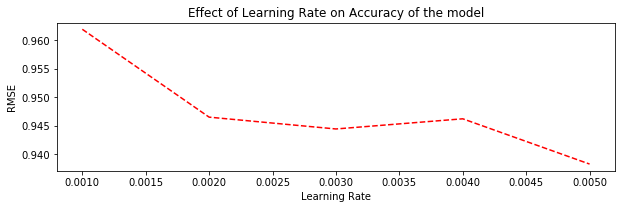

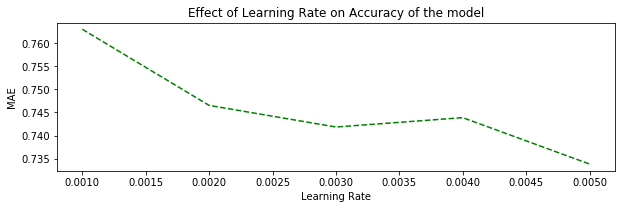

In [24]:
plt.figure(figsize=(10,6))
plt.subplot(2,1,1)
plt.plot(n_ep,rm,'r--')
plt.xlabel('Learning Rate')
plt.ylabel('RMSE')
plt.title('Effect of Learning Rate on Accuracy of the model')
plt.figure(figsize=(10,6))
plt.subplot(2,1,1)
plt.plot(n_ep,mae_svd,'g--')
plt.xlabel('Learning Rate')
plt.ylabel('MAE')
plt.title('Effect of Learning Rate on Accuracy of the model')

## KNN Collaborative Filtering

In [25]:
## define algorithm config
algo_name = KNNBasic ##  KNNWithMeans,KNNBaseline
sim_option={'name': 'cosine', ## cosine, msd, pearson, personbaseline
                 'user_based': 'False', ## False for item-based
                 'min_surpport':0 }##  if |Iuv|<min_support then sim(u,v)=0
max_k = 10 ## The (max) number of neighbors to take into account for aggregation
min_k = 7 ##  If there are not enough neighbors, the prediction is set the the global mean of all ratings

In [26]:
knn_default = algo_name(k = max_k, min_k = min_k, sim_options=sim_option)

In [27]:
#Train model
perf = evaluate(knn_default, dt, measures=['RMSE','MAE'], verbose= 1)
defaultknn_prediction=knn_default.test(testset)

Evaluating RMSE, MAE of algorithm KNNBasic.

------------
Fold 1
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 1.0060
MAE:  0.7838
------------
Fold 2
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.9997
MAE:  0.7719
------------
Fold 3
Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.9914
MAE:  0.7854
------------
------------
Mean RMSE: 0.9990
Mean MAE : 0.7804
------------
------------


In [28]:
#Accuracy on test set
rmse(defaultknn_prediction)
mae(defaultknn_prediction)

RMSE: 1.0328
MAE:  0.8092


0.80919919776828553

#### Changing hyper-paramater of KNN

In [29]:
algo_name = KNNBasic
#Define the different hyper-paramter range
grid_param = {'k':[5,10,20,30,35,40,50],
             'min_k':[3,4,5,6,7,8,9,10,11,12],
             'sim_options':{'name':['msd','cosine','pearson'],
                           'min_surpport':[0,3,5],
                           'user_based':[False]}
             }

In [30]:
grid_search = surprise.GridSearch(algo_name, grid_param, measures=['RMSE', 'MAE'],verbose = 0)
grid_search.evaluate(dt)

[{'k': 5, 'min_k': 3, 'sim_options': {'name': 'msd', 'min_surpport': 0, 'user_based': False}}, {'k': 5, 'min_k': 3, 'sim_options': {'name': 'msd', 'min_surpport': 3, 'user_based': False}}, {'k': 5, 'min_k': 3, 'sim_options': {'name': 'msd', 'min_surpport': 5, 'user_based': False}}, {'k': 5, 'min_k': 3, 'sim_options': {'name': 'cosine', 'min_surpport': 0, 'user_based': False}}, {'k': 5, 'min_k': 3, 'sim_options': {'name': 'cosine', 'min_surpport': 3, 'user_based': False}}, {'k': 5, 'min_k': 3, 'sim_options': {'name': 'cosine', 'min_surpport': 5, 'user_based': False}}, {'k': 5, 'min_k': 3, 'sim_options': {'name': 'pearson', 'min_surpport': 0, 'user_based': False}}, {'k': 5, 'min_k': 3, 'sim_options': {'name': 'pearson', 'min_surpport': 3, 'user_based': False}}, {'k': 5, 'min_k': 3, 'sim_options': {'name': 'pearson', 'min_surpport': 5, 'user_based': False}}, {'k': 5, 'min_k': 4, 'sim_options': {'name': 'msd', 'min_surpport': 0, 'user_based': False}}, {'k': 5, 'min_k': 4, 'sim_options': {'

In [31]:
grid_search.best_params['RMSE']

{'k': 10,
 'min_k': 7,
 'sim_options': {'min_surpport': 0, 'name': 'msd', 'user_based': False}}

In [32]:
grid_search.best_score['RMSE']

1.0290302751938731

In [33]:
grid_search.best_params['MAE']

{'k': 10,
 'min_k': 10,
 'sim_options': {'min_surpport': 0, 'name': 'msd', 'user_based': False}}

In [34]:
grid_search.best_score['MAE']

0.79473625590763086

In [692]:
### get the result of different hyper-parameter

In [35]:
#
results_df = pd.DataFrame.from_dict(grid_search.cv_results)
plotdata = results_df.loc[:,['MAE','RMSE','k','min_k']]
name_list = []
min_surppot_list = []
for param in results_df.params:
#     print(param)
    name_list.append(param['sim_options']['name'])
    min_surppot_list.append(param['sim_options']['min_surpport'])
    
name_list = pd.Series(name_list)
min_surppot_list = pd.Series(min_surppot_list)

plotdata['sim_matric'] = name_list
plotdata['min_support'] = min_surppot_list
plotdata.head()

,MAE,RMSE,k,min_k,sim_matric,min_support
0,0.802858,1.046292,5,3,msd,0
1,0.802858,1.046292,5,3,msd,3
2,0.802858,1.046292,5,3,msd,5
3,0.819836,1.067897,5,3,cosine,0
4,0.819836,1.067897,5,3,cosine,3


In [36]:
plotdata_max_k = plotdata[plotdata.min_k == 7]
plotdata_max_k = plotdata_max_k[plotdata_max_k.min_support == 0]
plotdata_max_k = plotdata_max_k[plotdata_max_k.sim_matric == 'cosine']
plotdata_max_k

,MAE,RMSE,k,min_k,sim_matric,min_support
39,0.808246,1.049066,5,7,cosine,0
129,0.807933,1.043418,10,7,cosine,0
219,0.809178,1.040984,20,7,cosine,0
309,0.810160,1.041568,30,7,cosine,0
399,0.810287,1.041772,35,7,cosine,0
489,0.810437,1.041895,40,7,cosine,0
579,0.810437,1.041895,50,7,cosine,0


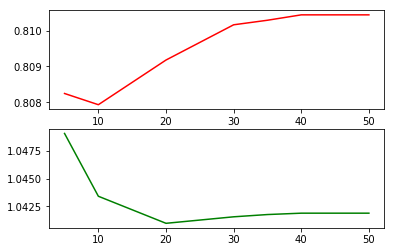

In [37]:
plt.subplot(2, 1, 1) 
plt.plot(plotdata_max_k.k, plotdata_max_k.MAE, 'r')
plt.subplot(2, 1, 2)
plt.plot(plotdata_max_k.k, plotdata_max_k.RMSE, 'g')
plt.show()

In [38]:
plotdata_mink = plotdata[plotdata.sim_matric =='cosine']
plotdata_mink = plotdata_mink[plotdata_mink.min_support == 0]
plotdata_mink = plotdata_mink[plotdata_mink.k == 10]
plotdata_mink

,MAE,RMSE,k,min_k,sim_matric,min_support
93,0.815340,1.054859,10,3,cosine,0
102,0.809976,1.046515,10,4,cosine,0
111,0.813041,1.047050,10,5,cosine,0
120,0.813336,1.045977,10,6,cosine,0
129,0.807933,1.043418,10,7,cosine,0
138,0.806126,1.042872,10,8,cosine,0
147,0.805204,1.043782,10,9,cosine,0
156,0.804364,1.043802,10,10,cosine,0
165,0.808246,1.049066,10,11,cosine,0
174,0.808246,1.049066,10,12,cosine,0


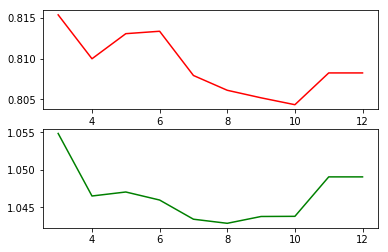

In [39]:
plt.subplot(2, 1, 1) 
plt.plot(plotdata_mink.min_k, plotdata_mink.MAE, 'r')
plt.subplot(2, 1, 2)
plt.plot(plotdata_mink.min_k, plotdata_mink.RMSE, 'g')
plt.show()

In [40]:
plotdata_sim = plotdata[plotdata.min_k == 7]
plotdata_sim = plotdata_sim[plotdata_sim.min_support == 0]
plotdata_sim = plotdata_sim[plotdata_sim.k == 10]
plotdata_sim

,MAE,RMSE,k,min_k,sim_matric,min_support
126,0.796707,1.029030,10,7,msd,0
129,0.807933,1.043418,10,7,cosine,0
132,0.812054,1.044120,10,7,pearson,0


# Metrics - Coverage

In [41]:
#Function to calculate coverage ratio
def coverage_ratio(predictions, n):
    top_n = get_top_n(predictions, n)
    product_list = []
    recommended_list = []
    for uid, iid, true_r, est, _ in predictions:
        product_list.append(iid)
    for uid, user_ratings in top_n.items():
        recommended_list.append(user_ratings[0][0])
    coverage = float(len(set(recommended_list))) / float(len(set(product_list)))
    return coverage

In [42]:
#Function to predict missing values based on an algorithm
def mv_prediction(algo,missing_values):
    predictions = [algo.predict(uid, iid)
                       for (uid, iid) in missing_values]
    return predictions

Baseline Coverage Ratio

In [44]:
mv_blprediction = mv_prediction(algo1,missing_values)
coverage_ratio(mv_blprediction,7)

0.14285714285714285

SVD Coverage Ratio

In [45]:
mv_svdprediction = mv_prediction(algo2,missing_values)
coverage_ratio(mv_svdprediction,7)

0.22857142857142856

KNN Coverage ratio

In [46]:
mv_knnprediction = mv_prediction(knn_default,missing_values)
coverage_ratio(mv_knnprediction,7)

0.35714285714285715